# Challenge Telecom X - Parte 2
Este projeto é sequência do [anterior](https://colab.research.google.com/drive/1n3aiNJ9Z5P6EtchNBg_jXUpgCj30mYiU?usp=sharing) que consistia em fazer uma análise exploratória dos dados de uma empresa de telecom, visando identificar possíveis motivos da evasão de clientes.

Agora, dei um passo a mais e aplico técnicas de *machine learning* no *dataset*.

O início desse *notebook* será similar ao do projeto anterior, pois consiste no carregamento dos dados, limpeza e alguns gráficos para nos ajudar no decorrer do projeto.

Caso queira pular direto para a parte que foi adicionada, você pode clicar no índicd no canto superior esquerdo do *notebook* e navegar até o título "Preparação para o Modelo".

# Problema
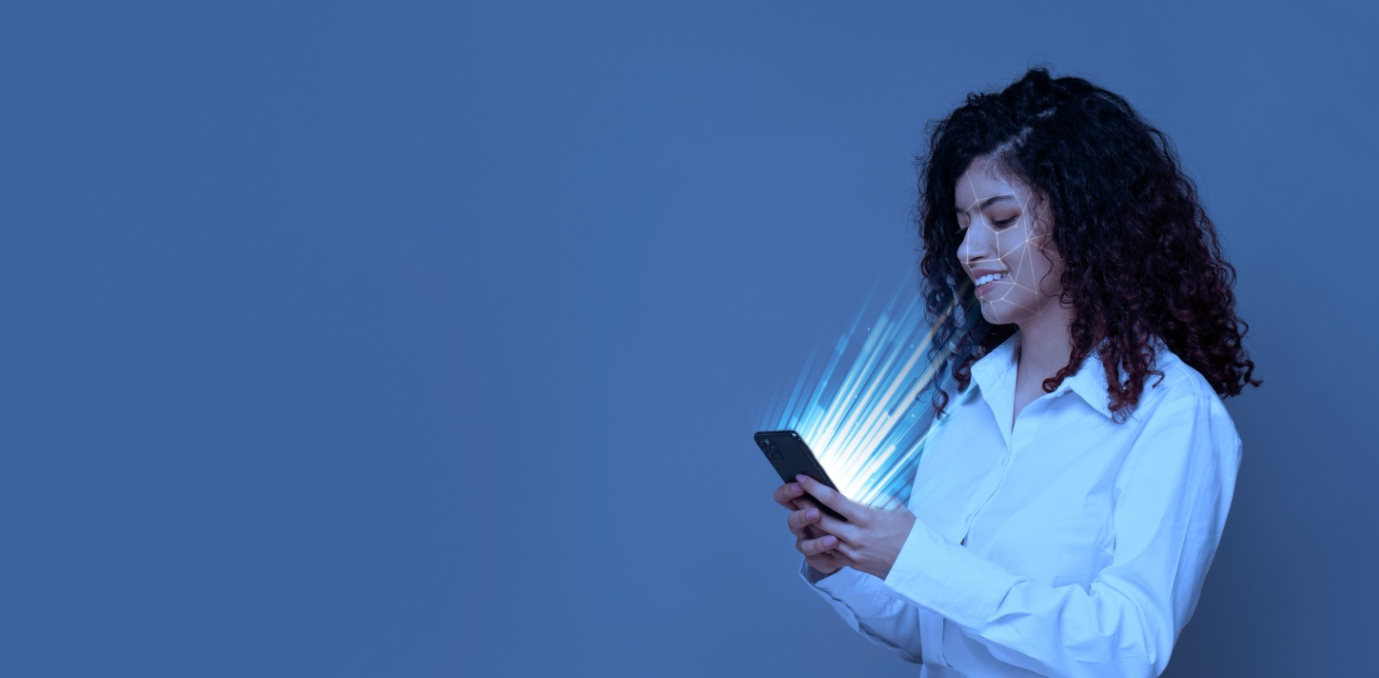

A taxa de churn representa o percentual de clientes que deixam de utilizar os serviços de uma empresa em um determinado período. No contexto de uma empresa de telecomunicações, o churn corresponde, por exemplo, aos clientes que cancelam seu plano de internet ou de telefonia móvel.

De forma geral, podemos classificar o churn em dois grandes grupos:

* Churn involuntário: Ocorre por fatores externos à vontade do cliente, como a interrupção de serviços em determinada região (ex.: a empresa decide encerrar operações em um bairro) ou o cancelamento por inadimplência devido a atrasos ou falta de pagamento.

* Churn voluntário: Resulta da decisão consciente do cliente em encerrar o serviço. As principais razões incluem insatisfação com a qualidade, migração para concorrentes com melhores preços ou planos, ou até mesmo dificuldades financeiras.

Entender o perfil dos clientes que evadem é fundamental para criar estratégias de retenção e melhorar a experiência do usuário.

O objetivo deste trabalho é identificar variáveis e atributos que possam estar influenciando na alta do churn em uma empresa de telecom.

# Imports

In [73]:
#imports antigos
import pandas as pd
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

#imports novos
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, recall_score, accuracy_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
#from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Extração

Os dados foram disponbilizados via github em um arquivo .json. Nesta etapa, os dados são lidos e padronizados.

In [74]:
url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science/main/TelecomX_Data.json"  # Raw URL
df_raw = pd.read_json(url)
df_raw.head(3)

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


## Normalizando o dataframe e padronizando colunas

In [75]:
# df_normalized = df_n
df_n = df_raw.copy()

df_n = df_n.join(pd.json_normalize(df_n['customer']))
df_n = df_n.join(pd.json_normalize(df_n['phone']))
df_n = df_n.join(pd.json_normalize(df_n['internet']))
df_n = df_n.join(pd.json_normalize(df_n['account']))

# Remove as colunas originais que eram dicionários
df_n.drop(['customer', 'phone', 'internet', 'account'], axis=1, inplace=True)

df_n.head(1)

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3


In [76]:
df_n = df_n.rename(columns={'customerID': 'CustomerID', 'gender': 'Gender', 'tenure': 'Tenure', 'Charges.Monthly': 'ChargesMonthly','Charges.Total': 'ChargesTotal'})
df_n.head(1)

,CustomerID,Churn,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,ChargesMonthly,ChargesTotal
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3


## Dicionário de dados

Dicionário de dados
* `CustomerID`: número de identificação único de cada cliente
* `Churn`: se o cliente deixou ou não a empresa
* `Gender`: gênero (masculino e feminino)
* `SeniorCitizen`: informação sobre um cliente ter ou não idade igual ou maior que 65 anos
* `Partner`: se o cliente possui ou não um parceiro ou parceira
* `Dependents`: se o cliente possui ou não dependentes
* `Tenure`: meses de contrato do cliente
* `PhoneService`: assinatura de serviço telefônico
* `MultipleLines`: assisnatura de mais de uma linha de telefone
* `InternetService`: assinatura de um provedor internet
* `OnlineSecurity`: assinatura adicional de segurança online
* `OnlineBackup`: assinatura adicional de backup online
* `DeviceProtection`: assinatura adicional de proteção no dispositivo
* `TechSupport`: assinatura adicional de suporte técnico, menos tempo de espera
* `StreamingTV`: assinatura de TV a cabo
* `StreamingMovies`: assinatura de streaming de filmes
* `Contract`: tipo de contrato
* `PaperlessBilling`: se o cliente prefere receber online a fatura
* `PaymentMethod`: forma de pagamento
* `ChargesMonthly`: total de todos os serviços do cliente por mês
* `ChargesTotal`: total gasto pelo cliente

# Transformação

Análise e tratamento de variáveis, nulos e colunas desnecessárias.

## Análise dos tipos de dados e correções

In [77]:
print(f'Variáveis do dataset: {df_n.shape[1]}\nTotal de linhas do dastaset: {df_n.shape[0]}\n')

Variáveis do dataset: 21
Total de linhas do dastaset: 7267



In [78]:
df_n.dtypes

,0
CustomerID,object
Churn,object
Gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
Tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object


In [79]:
# notei que a coluna ChargesTotal não está como float como deveria ser, portanto corrijo ela
df_n['ChargesTotal'] = pd.to_numeric(df_n['ChargesTotal'], errors='coerce')

## Análise de nulos e correções

In [80]:
# verficando valores nulos. Existem 11 casos na coluna ChargesTotal.
df_n.isnull().sum()

,0
CustomerID,0
Churn,0
Gender,0
SeniorCitizen,0
Partner,0
Dependents,0
Tenure,0
PhoneService,0
MultipleLines,0
InternetService,0


In [81]:
# Eu poderia preencher eles com a média, mas vou dropar essas linhas por representarem apenas 0,1% da amostra.
df_n = df_n.dropna(subset=['ChargesTotal'])
print(f'Total de valores vazios na variável TotalCharges após o tratamento é de: {df_n["ChargesTotal"].isnull().sum()}.\
      \nO total de linhas do dataset é: {df_n.shape[0]}')

Total de valores vazios na variável TotalCharges após o tratamento é de: 0.      
O total de linhas do dataset é: 7256


## Valores únicos das colunas categóricas

Aqui é possível notar que na coluna churn existe o valor vazio ''. Como esse valor não está preenchido e é um valor determinante, eu excluo os registro do dataset.

Ao todo são 224 casos.

Também é possível ver que temos vários valores em colunas com "no internet service" e temos uma coluna chamada "InternetService" que indica qual tipo de internet a pessoa tem ou se não tem. Possivelmente quando aplicarmos o encoding nas colunas categóricas, teremos oportunidade de dropar novas colunas.

In [82]:
# imprimindo os valores únicos das colunas não numéricas
colunas = df_n.columns.tolist()#[1:] # se tivesse a coluna de id que eu dropei
for coluna in colunas:
  if df_n[coluna].dtype == 'object':
    print(f'Coluna {coluna}: {df_n[coluna].unique()}')


Coluna CustomerID: ['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
Coluna Churn: ['No' 'Yes' '']
Coluna Gender: ['Female' 'Male']
Coluna Partner: ['Yes' 'No']
Coluna Dependents: ['Yes' 'No']
Coluna PhoneService: ['Yes' 'No']
Coluna MultipleLines: ['No' 'Yes' 'No phone service']
Coluna InternetService: ['DSL' 'Fiber optic' 'No']
Coluna OnlineSecurity: ['No' 'Yes' 'No internet service']
Coluna OnlineBackup: ['Yes' 'No' 'No internet service']
Coluna DeviceProtection: ['No' 'Yes' 'No internet service']
Coluna TechSupport: ['Yes' 'No' 'No internet service']
Coluna StreamingTV: ['Yes' 'No' 'No internet service']
Coluna StreamingMovies: ['No' 'Yes' 'No internet service']
Coluna Contract: ['One year' 'Month-to-month' 'Two year']
Coluna PaperlessBilling: ['Yes' 'No']
Coluna PaymentMethod: ['Mailed check' 'Electronic check' 'Credit card (automatic)'
 'Bank transfer (automatic)']


In [83]:
len(df_n[df_n['Churn'] == ''])

224

In [84]:
_churn_vazio = len(df_n[df_n['Churn'] == ''])
_comprimento_df = len(df_n)
print(f'Temos {_churn_vazio} linhas sem valor na coluna Churn de um total de {_comprimento_df} linhas.')

Temos 224 linhas sem valor na coluna Churn de um total de 7256 linhas.


In [85]:
df_n = df_n[df_n['Churn'] != '']

_comprimento_df = len(df_n)
_churn_vazio = len(df_n[df_n['Churn'] == ''])
print(f'Temos {_churn_vazio} linhas sem valor na coluna Churn de um total de {_comprimento_df} linhas.')

Temos 0 linhas sem valor na coluna Churn de um total de 7032 linhas.


## Drop de colunas desnecessárias

In [86]:
df_n.drop("CustomerID", axis = 1, inplace = True)

/tmp/ipython-input-1328110071.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [87]:
df_n.head()

,Churn,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,ChargesMonthly,ChargesTotal
0,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30
1,No,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40
2,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40


## Indicadores estatísticos das colunas numéricas

In [88]:
# describe das colunas numéricas
df_n.describe()

,SeniorCitizen,Tenure,ChargesMonthly,ChargesTotal
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


# Carga e análise

Análise exploratória gráfica dos dados.

## Correlação entre variáveis com a variável churn

O método [get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) transforma os valores categóricos em números *( variáveis dummies também chamadas de one-hot encoded)* e a partir daí fazemos uma correlação.

As variáveis dummies são colunas binárias que representam a presença de cada categoria de uma variável categórica.

    No gráfico podemos notar uma correlação positiva com o churn quando o Contrato é mês a mês, OnlineSecurity e TechSupport = não.

    Enquanto temos uma correlação negativa com o churn quando o cliente tem um Tenure alto e contrato = 2 anos.

    As colunas de Gender, PhoneService, MultipleLines, StreamingMovies, StreamingTV possuem correlação bem perto de zero.
    Isso pode indicar que são pouco influentes na decisão do Churn.

  Verificaremos essas informações adiante



In [89]:
df_dummies = df_n.copy()
#df_dummies = df_dummies.drop(['CustomerID'], axis=1)
# converter o churn em valor numérico antes de aplicar o dummies
df_dummies['Churn'] = df_n['Churn'].replace({'Yes': 1, 'No': 0})
df_dummies = pd.get_dummies(df_dummies, dtype=int)
df_dummies.head(3)

,Churn,SeniorCitizen,Tenure,ChargesMonthly,ChargesTotal,Gender_Female,Gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,9,65.6,593.30,1,0,0,1,0,...,0,0,1,0,0,1,0,0,0,1
1,0,0,9,59.9,542.40,0,1,1,0,1,...,1,1,0,0,1,0,0,0,0,1
2,1,0,4,73.9,280.85,0,1,1,0,1,...,0,1,0,0,0,1,0,0,1,0


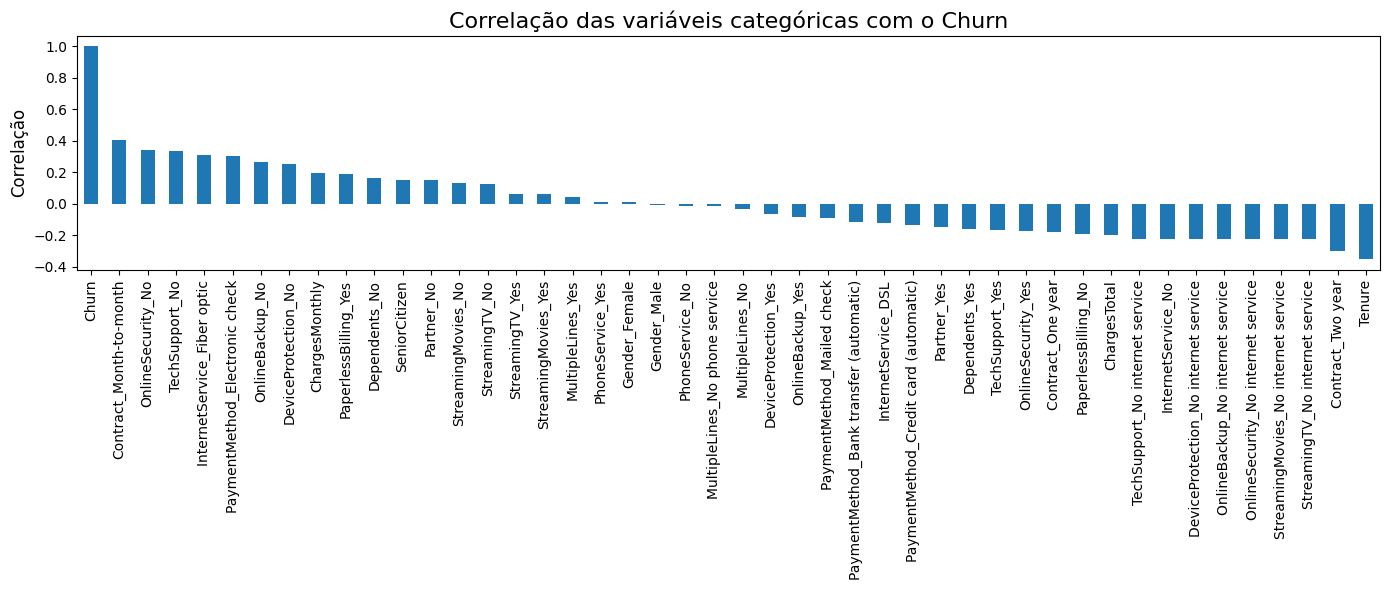

In [90]:
plt.figure(figsize=(14,6))
df_dummies.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')
plt.ylabel('Correlação', fontsize=12)
plt.title('Correlação das variáveis categóricas com o Churn', fontsize=16)
plt.tight_layout()
#plt.xticks(rotation=45, ha='right')
plt.show();

## Taxa de churn

Após limpar a base, temos 73,42% da base ainda ativa e 26,58% que não são mais clientes.

In [91]:
percentual_churn = round((df_n['Churn'].value_counts(normalize=True) * 100),2)
percentual_churn = percentual_churn.rename("Percentual %").reset_index()

fig = px.bar(percentual_churn, x='Churn', y='Percentual %', color='Churn')
fig.update_layout(title='Taxa de Churn',title_x=0.5,autosize=False,width=1200,height=450)
fig.show()

## Churn por tenure

Podemos notar em ambos os gráficos que a maior quantidade de pessoas que evadem da empresa possuem poucos meses que são clientes.

A mediana dos clientes que evadem é de 10 meses, enquanto de quem ainda é cliente é de 38 meses.

In [92]:
fig = px.box(df_n, x="Churn", y="Tenure", color="Churn")
fig.update_layout(title='Qtd de Churn por Tenure',title_x=0.5,autosize=False,width=1200,height=500)
fig.show()

In [93]:
churn_tenure = df_n.groupby(['Churn'])['Tenure'].value_counts().reset_index().rename(columns={"count":"Qtd Churn"})
fig = px.bar(churn_tenure, x='Tenure', y='Qtd Churn', color='Churn')
fig.update_layout(title='Qtd de Churn por Tenure',title_x=0.5,autosize=False,width=1200,height=500)
fig.show()

In [94]:
# churn_tenure = round(df_n.groupby('Churn')['Tenure'].value_counts(normalize=True).mul(100).reset_index(name='Percentual'),2)

# fig = px.bar(churn_tenure, x='Tenure', y='Percentual', color='Churn')
# fig.update_layout(title='Percentual de Churn por Tenure',title_x=0.5,autosize=False,width=1200,height=500)
# fig.show()

## Taxa de churn por contrato

Podemos observar que 88% do churn está localizado em contratos mês a mês, o que pode significar que um cliente sem um contrato com fidelidade está mais sujeito ao churn.

In [95]:
churn_contrato = round(df_n.groupby('Churn')['Contract'].value_counts(normalize=True).mul(100).reset_index(name='Percentual'),2).sort_values(by='Contract')
fig = px.bar(churn_contrato, x='Contract', y='Percentual', color='Churn', barmode='group')
fig.update_layout(title='Taxa de Churn por Contrato', title_x=0.5, autosize=False, width=1200, height=500)
fig.show()

In [96]:
# agrupado 100%
# churn_contrato = round(df_n.groupby('Contract')['Churn'].value_counts(normalize=True).mul(100).reset_index(name='Percentual'),2).sort_values(by='Contract')
# fig = px.bar(churn_contrato, x='Contract', y='Percentual', color='Churn')
# fig.update_layout(title='Taxa de Churn por contrato', title_x=0.5, autosize=False, width=1200, height=500)
# fig.show()

## Taxa de Churn por senioridade

Quando olhamos para a taxa absoluta, a maior parte do churn está concentrada em clientes não sêniors, pois também são a maior parte da base.
A relação de clientes seniores é de 12,9% da base enquanto o churn é de 24,5% algo que pode ser importante acompanhar, mas devido a baixa representividade na base pode ser algo que seja atacado posteriormente.




In [97]:
churn_senioridade = round(df_n.groupby('Churn')['SeniorCitizen'].value_counts(normalize=True).mul(100).reset_index(name='Percentual'),2).sort_values(by='SeniorCitizen')
#churn_senioridade = df_n.groupby(['Churn'])['SeniorCitizen'].value_counts().reset_index().rename(columns={"count":"Qtd Churn"})
#churn_senioridade = round(df_n.groupby('SeniorCitizen')['Churn'].value_counts(normalize=True).mul(100).reset_index(name='Percentual'),2).sort_values(by='SeniorCitizen')
churn_senioridade['SeniorCitizen'] = churn_senioridade['SeniorCitizen'].replace({1: 'Senior', 0: 'Outras idades'})
fig = px.bar(churn_senioridade, x='SeniorCitizen', y='Percentual', color='Churn',barmode='group')
fig.update_layout(title='Taxa de Churn por Senioridade', title_x=0.5, autosize=False, width=1200, height=500)
fig.show()

## Churn em relação às contas mensais

Tanto no histograma quanto no gráfico de densidade é possível notar que a maior parte do churn está contida nas contas mensais com alto valor.

In [98]:
df_churn_monthly_charge = df_n[['Churn','ChargesMonthly']]
fig = px.histogram(df_churn_monthly_charge, x='ChargesMonthly', color='Churn', nbins=60)
fig.update_layout(title='Distribuição do valor das contas mensais e Churn',title_x=0.5,autosize=False,width=1200,height=500, yaxis_title='Qtd')
fig.show()

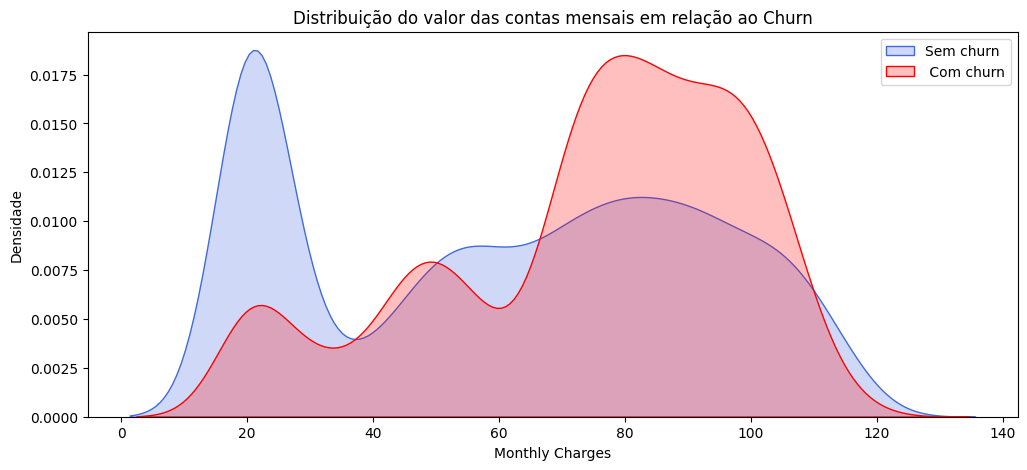

In [99]:
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.figure(figsize=(12, 5))
ax = sns.kdeplot(df_n.ChargesMonthly[(df_n['Churn']=='No')],
                 color='royalblue', shade = True)

ax = sns.kdeplot(df_n.ChargesMonthly[(df_n['Churn']=='Yes')],
                 color='red', shade = True)

ax.legend(["Sem churn"," Com churn"],loc='upper right')
ax.set_ylabel('Densidade')
ax.set_xlabel('Monthly Charges')
ax.set_title('Distribuição do valor das contas mensais em relação ao Churn');

## Churn em relação às contas totais

Tanto no gráfico histograma quanto no de densidade, o churn está concentrado nas contas totais menores.

Se olharmos só esse gráfico podemos ter uma interpretação equivocada. Mas sabendo que o churn está mais concentrado em clientes com um baixo tenure (tempo de casa), faz sentido a conta total destas pessoas ser menor do que de clientes que tem 2,3,4x mais tempo de casa.

In [100]:
df_churn_monthly_charge = df_n[['Churn','ChargesTotal']]
fig = px.histogram(df_churn_monthly_charge, x='ChargesTotal', color='Churn', nbins=60)
fig.update_layout(title='Distribuição do valor das contas totais e Churn',title_x=0.5,autosize=False,width=1200,height=500, yaxis_title='Qtd')
fig.show()

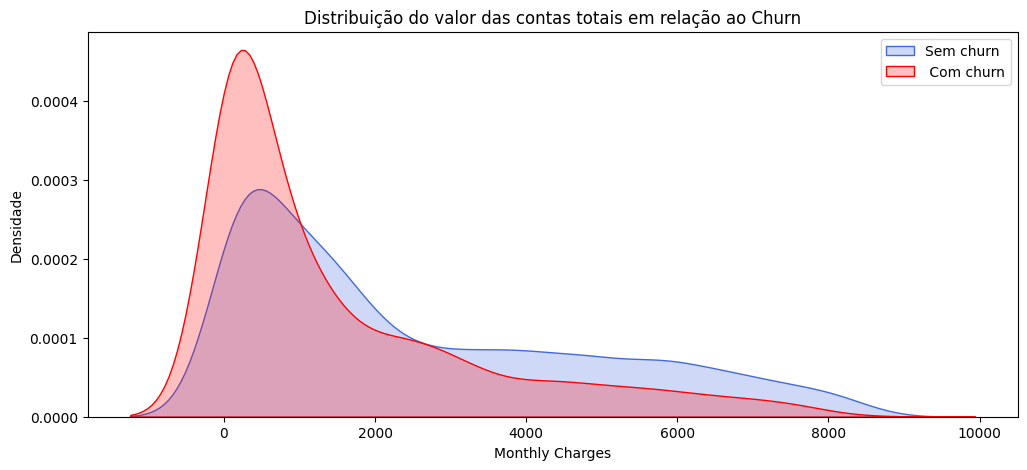

In [101]:
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.figure(figsize=(12, 5))
ax = sns.kdeplot(df_n.ChargesTotal[(df_n['Churn']=='No')],
                 color='royalblue', shade = True)

ax = sns.kdeplot(df_n.ChargesTotal[(df_n['Churn']=='Yes')],
                 color='red', shade = True)

ax.legend(["Sem churn"," Com churn"],loc='upper right')
ax.set_ylabel('Densidade')
ax.set_xlabel('Monthly Charges')
ax.set_title('Distribuição do valor das contas totais em relação ao Churn');

## Taxa de churn pelo produto OnlineSecurity

Esta é uma das colunas que estava em evidência na correlação positiva do churn quando o valor dela era "No".

Aqui podemos ver que para os clientes sem churn, está quase igualmente distribuído na casa dos 33%, enquanto para clientes com churn o fato de não ter o produto OnlineSecurity acusa 78% do total destes clientes.

Como é o fato de não ter um produto, não consigo afirmar que a falta dele realmente impacta ou é uma coincidência. Se fosse o contrário, poderíamos afirmar que é um produto ruim ou caro e está gerando churn, mas não é o caso.


In [102]:
churn_online_security = round(df_n.groupby('Churn')['OnlineSecurity'].value_counts(normalize=True).mul(100).reset_index(name='Percentual'),2).sort_values(by='OnlineSecurity')
fig = px.bar(churn_online_security, x='OnlineSecurity', y='Percentual', color='Churn', barmode='group')
fig.update_layout(title='Taxa de Churn pelo produto OnlineSecurity', title_x=0.5, autosize=False, width=1200, height=500)
fig.show()

## Taxa de churn pelo produto TechSupport

Esta é uma das colunas que estava em evidência na correlação positiva do churn quando o valor dela era "No".

Aqui tenho a mesma conclusão do item anterior. O fato de não ter o produto ter um churn de 77% pode ser apenas um coincidência.

In [103]:
churn_tech_support = round(df_n.groupby('Churn')['TechSupport'].value_counts(normalize=True).mul(100).reset_index(name='Percentual'),2).sort_values(by='TechSupport')
fig = px.bar(churn_tech_support, x='TechSupport', y='Percentual', color='Churn', barmode='group')
fig.update_layout(title='Taxa de Churn pelo produto TechSupport', title_x=0.5, autosize=False, width=1200, height=500)
fig.show()

## Taxa de churn pelo tipo de serviço de internet

Fato interessante aqui, o serviço de internet do tipo fibra óptica que é mais moderno e possui altas velocidades possui mais churn do que o antigo DSL.

Isso pode ilustrar que o serviço oferecido na fibra óptica pode estar ruim. Essa tecnologia tem maior capacidade de receber clientes e entrega velocidades superiores, mas pode estar ocorrendo algo nesta companhia que faça esse serviço ser pior que o DSL.

In [104]:
churn_internet_service = round(df_n.groupby('Churn')['InternetService'].value_counts(normalize=True).mul(100).reset_index(name='Percentual'),2).sort_values(by='InternetService')
fig = px.bar(churn_internet_service, x='InternetService', y='Percentual', color='Churn', barmode='group')
fig.update_layout(title='Taxa de Churn pelo tipo de InternetService', title_x=0.5, autosize=False, width=1200, height=500)
fig.show()

## Distribuição de todas variáveis categóricas pelo churn em quantidade

Etapa criada para não ter que explorar coluna a coluna, mesmo as que não tinham influência no churn quando feita a correlação anteriormente.

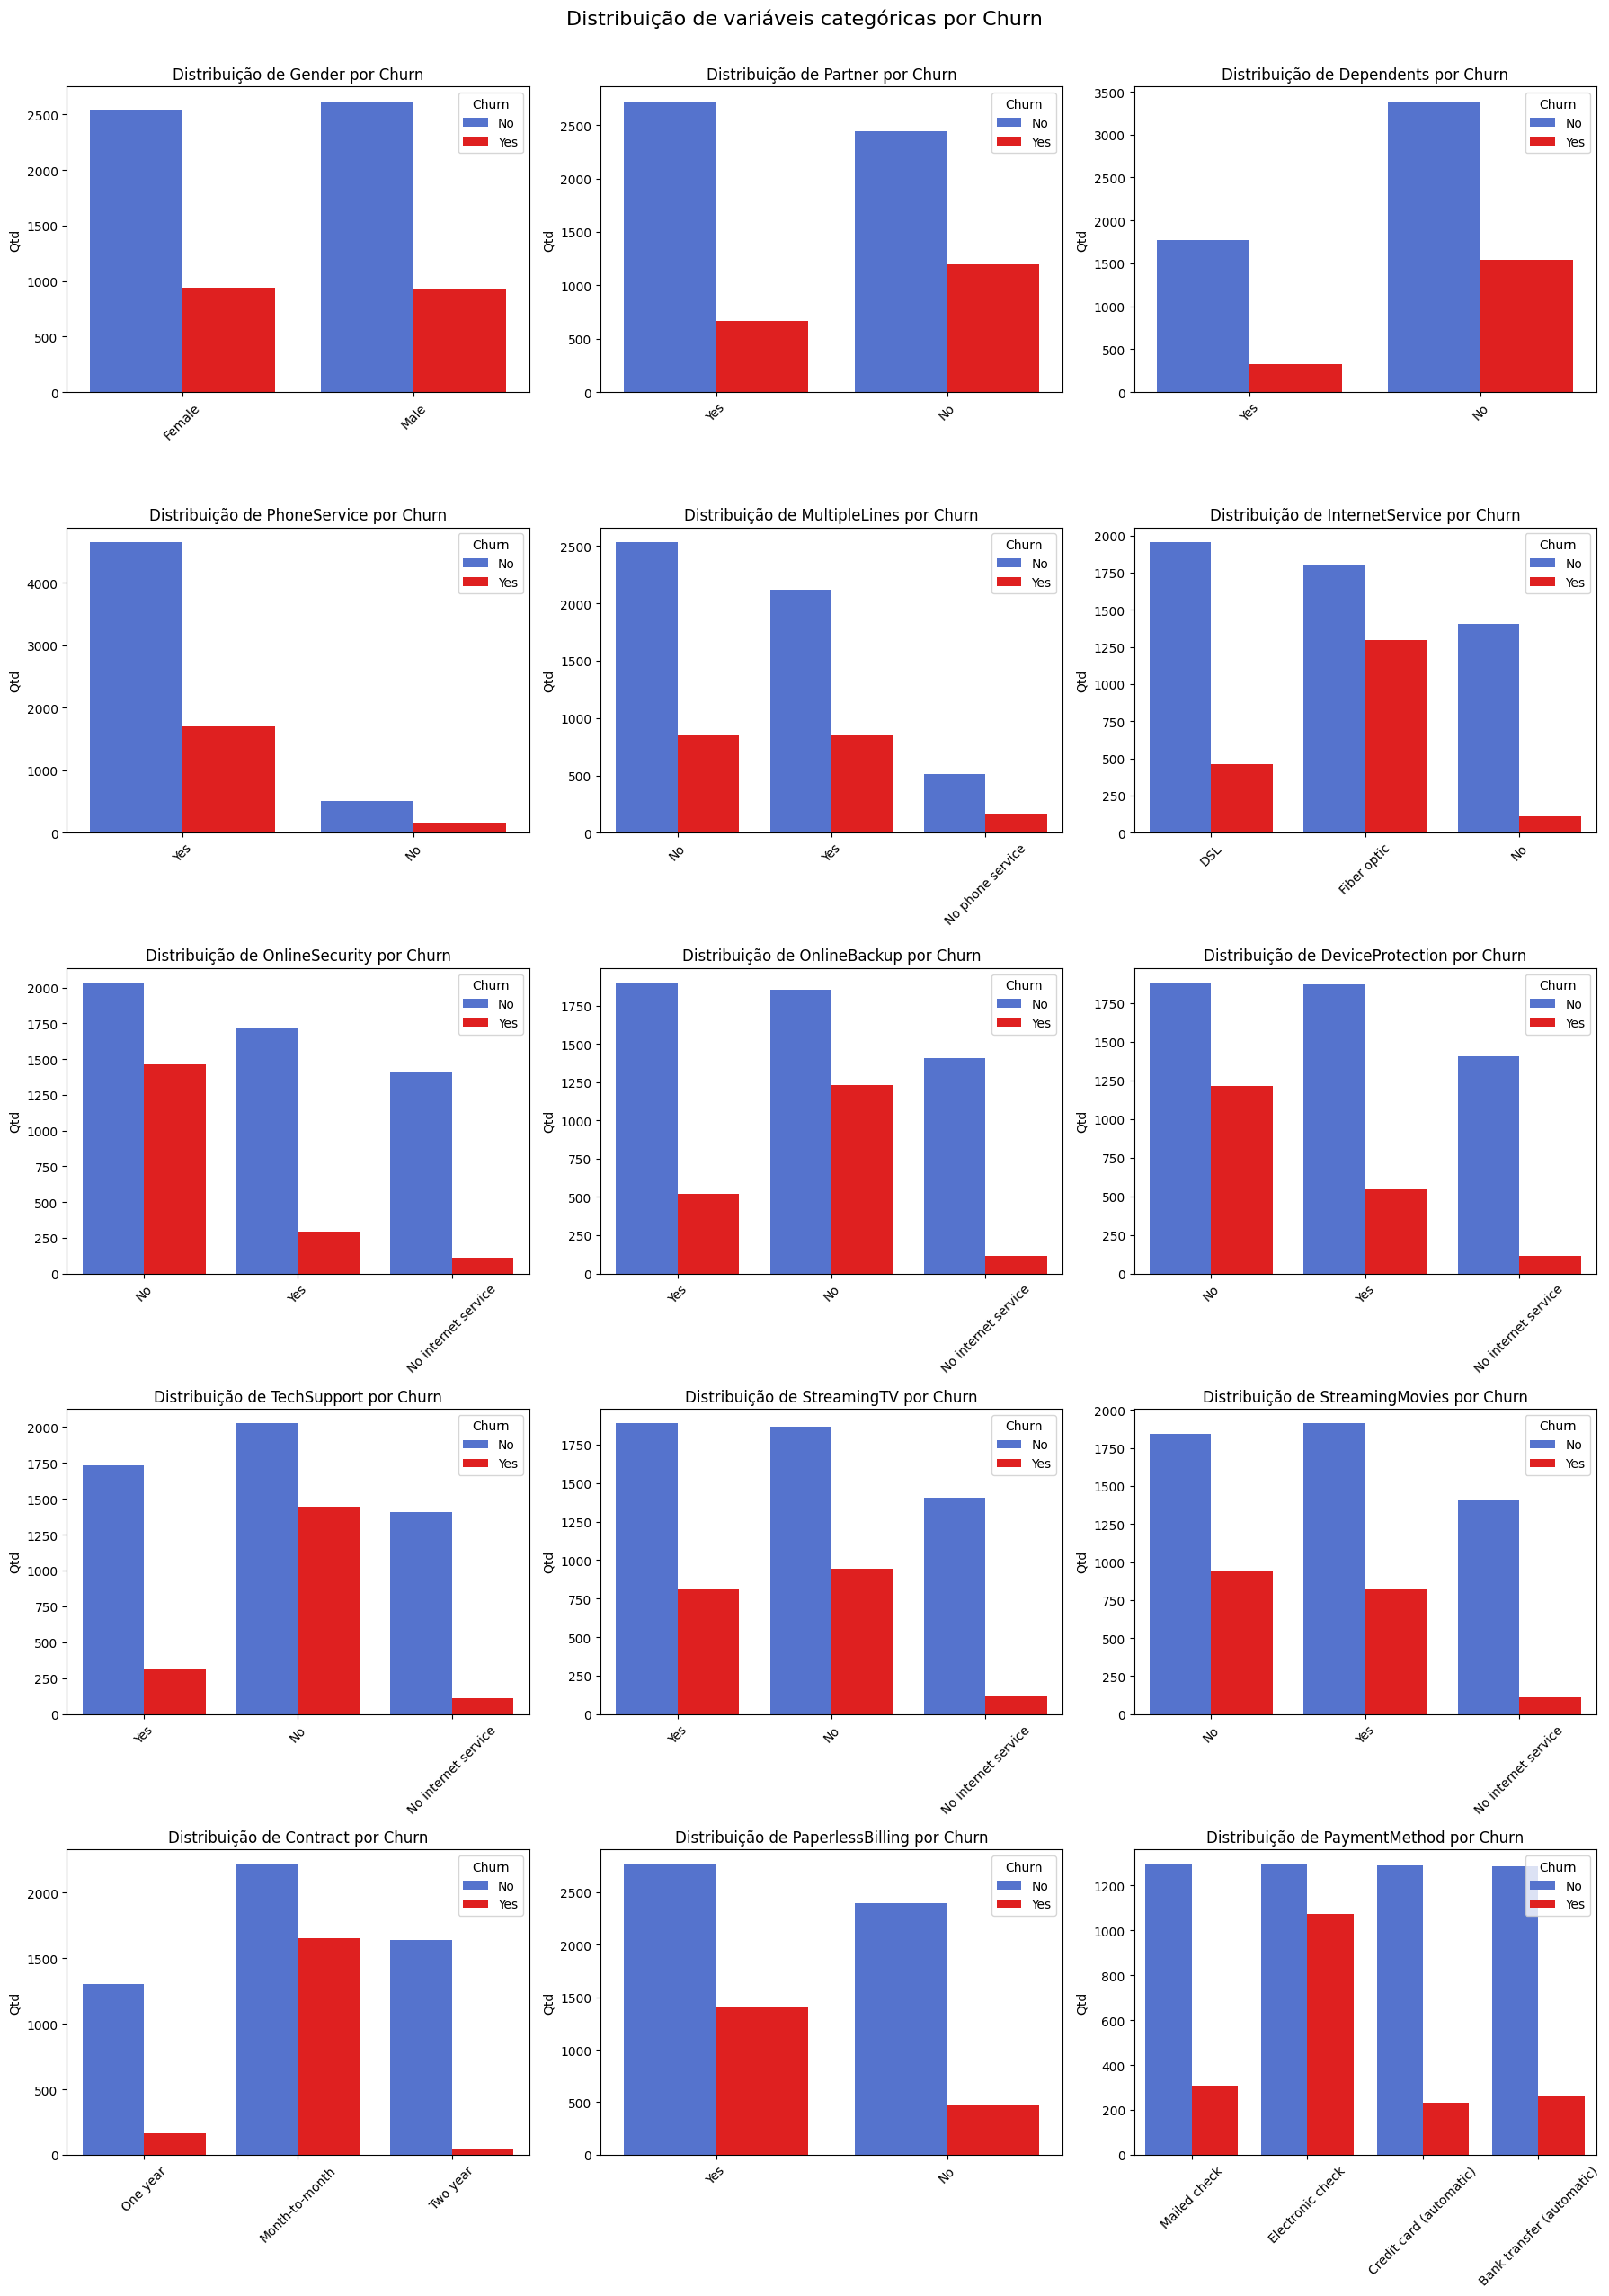

In [105]:
colunas = [
    'Gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaperlessBilling', 'PaymentMethod'
]

n_colunas = 3
n_linhas = -(-len(colunas) // n_colunas)  # Divide com arredondamento pra cima

plt.figure(figsize=(18, 5 * n_linhas))

for i, col in enumerate(colunas, 1):
    plt.subplot(n_linhas, n_colunas, i)
    sns.countplot(data=df_n, x=col, hue='Churn', palette=['royalblue', 'red'])
    plt.title(f'Distribuição de {col} por Churn')
    plt.xticks(rotation=45)
    plt.xlabel('')
    plt.ylabel('Qtd')
    plt.tight_layout()

plt.suptitle('Distribuição de variáveis categóricas por Churn', fontsize=16, y=1.02)
plt.show()


In [106]:
colunas = ['Gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaperlessBilling', 'PaymentMethod']

for col in colunas:
    print(f'\n Distribuição de Churn para: {col}')
    display(df_n.groupby([col, 'Churn']).size().unstack(fill_value=0))


 Distribuição de Churn para: Gender


Churn,No,Yes
Gender,,
Female,2544,939
Male,2619,930



 Distribuição de Churn para: Partner


Churn,No,Yes
Partner,,
No,2439,1200
Yes,2724,669



 Distribuição de Churn para: Dependents


Churn,No,Yes
Dependents,,
No,3390,1543
Yes,1773,326



 Distribuição de Churn para: PhoneService


Churn,No,Yes
PhoneService,,
No,510,170
Yes,4653,1699



 Distribuição de Churn para: MultipleLines


Churn,No,Yes
MultipleLines,,
No,2536,849
No phone service,510,170
Yes,2117,850



 Distribuição de Churn para: InternetService


Churn,No,Yes
InternetService,,
DSL,1957,459
Fiber optic,1799,1297
No,1407,113



 Distribuição de Churn para: OnlineSecurity


Churn,No,Yes
OnlineSecurity,,
No,2036,1461
No internet service,1407,113
Yes,1720,295



 Distribuição de Churn para: OnlineBackup


Churn,No,Yes
OnlineBackup,,
No,1854,1233
No internet service,1407,113
Yes,1902,523



 Distribuição de Churn para: DeviceProtection


Churn,No,Yes
DeviceProtection,,
No,1883,1211
No internet service,1407,113
Yes,1873,545



 Distribuição de Churn para: TechSupport


Churn,No,Yes
TechSupport,,
No,2026,1446
No internet service,1407,113
Yes,1730,310



 Distribuição de Churn para: StreamingTV


Churn,No,Yes
StreamingTV,,
No,1867,942
No internet service,1407,113
Yes,1889,814



 Distribuição de Churn para: StreamingMovies


Churn,No,Yes
StreamingMovies,,
No,1843,938
No internet service,1407,113
Yes,1913,818



 Distribuição de Churn para: Contract


Churn,No,Yes
Contract,,
Month-to-month,2220,1655
One year,1306,166
Two year,1637,48



 Distribuição de Churn para: PaperlessBilling


Churn,No,Yes
PaperlessBilling,,
No,2395,469
Yes,2768,1400



 Distribuição de Churn para: PaymentMethod


Churn,No,Yes
PaymentMethod,,
Bank transfer (automatic),1284,258
Credit card (automatic),1289,232
Electronic check,1294,1071
Mailed check,1296,308


# Preparação dos dados para o modelo
Aqui são aplicadas técnicas que se somam a limpeza feita anteriormente, visando garantir que os dados estejam "saudáveis" para serem treinados nos modelos.

## Transformações das variáveis explicativas e alvo
Nesta etapa é feita a cópia do *dataframe* que foi tratado anteriormente e aplicado métodos de transformação nas colunas binárias e não binárias.

Para as colunas binárias é utilizado o label encoding, enquanto para as outras  o *one hot encoding*.

Um fato importante é que existem várias colunas com valores "*no internet service*". Aqui pode-se transformar elas em colunas com o one hot encoding e depois dropar elas por serem redundantes, ou transfomar em "no", o que torna várias colunas em binárias. Foi escolhida a segunda opção.

Este tipo de ação é muito importante, pois em grandes *datasets*, remover redundâncias pode gerar economia de recursos e tempo.

In [107]:
df_ml = df_n.copy()

colunas = df_ml.columns.tolist()#[1:]
for coluna in colunas:
  if df_ml[coluna].dtype == 'object':
    print(f'Coluna {coluna}: {df_ml[coluna].unique()}')

Coluna Churn: ['No' 'Yes']
Coluna Gender: ['Female' 'Male']
Coluna Partner: ['Yes' 'No']
Coluna Dependents: ['Yes' 'No']
Coluna PhoneService: ['Yes' 'No']
Coluna MultipleLines: ['No' 'Yes' 'No phone service']
Coluna InternetService: ['DSL' 'Fiber optic' 'No']
Coluna OnlineSecurity: ['No' 'Yes' 'No internet service']
Coluna OnlineBackup: ['Yes' 'No' 'No internet service']
Coluna DeviceProtection: ['No' 'Yes' 'No internet service']
Coluna TechSupport: ['Yes' 'No' 'No internet service']
Coluna StreamingTV: ['Yes' 'No' 'No internet service']
Coluna StreamingMovies: ['No' 'Yes' 'No internet service']
Coluna Contract: ['One year' 'Month-to-month' 'Two year']
Coluna PaperlessBilling: ['Yes' 'No']
Coluna PaymentMethod: ['Mailed check' 'Electronic check' 'Credit card (automatic)'
 'Bank transfer (automatic)']


In [108]:
# transformando valores de colunas que possuem "no internet service" em "no"
servicos_internet = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies']

for col in servicos_internet:
    df_ml[col] = df_ml[col].replace({'No internet service': 'No'})

In [109]:
# transformando valores de colunas que possuem "No phone service" em "no"
df_ml['MultipleLines'] = df_ml['MultipleLines'].replace({'No phone service': 'No'})

In [110]:
colunas = df_ml.columns.tolist()#[1:]
for coluna in colunas:
  if df_ml[coluna].dtype == 'object':
    print(f'Coluna {coluna}: {df_ml[coluna].unique()}')

Coluna Churn: ['No' 'Yes']
Coluna Gender: ['Female' 'Male']
Coluna Partner: ['Yes' 'No']
Coluna Dependents: ['Yes' 'No']
Coluna PhoneService: ['Yes' 'No']
Coluna MultipleLines: ['No' 'Yes']
Coluna InternetService: ['DSL' 'Fiber optic' 'No']
Coluna OnlineSecurity: ['No' 'Yes']
Coluna OnlineBackup: ['Yes' 'No']
Coluna DeviceProtection: ['No' 'Yes']
Coluna TechSupport: ['Yes' 'No']
Coluna StreamingTV: ['Yes' 'No']
Coluna StreamingMovies: ['No' 'Yes']
Coluna Contract: ['One year' 'Month-to-month' 'Two year']
Coluna PaperlessBilling: ['Yes' 'No']
Coluna PaymentMethod: ['Mailed check' 'Electronic check' 'Credit card (automatic)'
 'Bank transfer (automatic)']


## Encoding para variáveis binárias
O encoding foi feito "manualmente" mas poderia ter sido usado o label encoder.

In [111]:
binarias = ['Churn', 'Gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
            'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
            'StreamingTV', 'StreamingMovies', 'PaperlessBilling']

for col in binarias:
  df_ml[col] = df_ml[col].map({'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0})

In [112]:
df_ml.head(2)

,Churn,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,ChargesMonthly,ChargesTotal
0,0,0,0,1,1,9,1,0,DSL,0,1,0,1,1,0,One year,1,Mailed check,65.6,593.3
1,0,1,0,0,0,9,1,1,DSL,0,0,0,0,0,1,Month-to-month,0,Mailed check,59.9,542.4


## Encoding variáveis não binárias
Pode-se usar o *OneHotEncoder*() ou o *pd.get_dummies*(). Cada um deles tem uma característica, sendo o OneHotEncoder() mais "profissional" e se comporta bem caso os dados mudem.

Como neste caso o *dataset* é fixo, foi escolhido por seguir com o *pd.get_dummies().*

O *drop_first=True* evita multicolinearidade (especialmente útil para LogisticRegression)

In [113]:
multicat_cols = ['InternetService', 'Contract', 'PaymentMethod']
df_ml = pd.get_dummies(df_ml, columns=multicat_cols, drop_first=True, dtype=int)
df_ml.head(2)

,Churn,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,...,PaperlessBilling,ChargesMonthly,ChargesTotal,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,0,1,1,9,1,0,0,1,...,1,65.6,593.3,0,0,1,0,0,0,1
1,0,1,0,0,0,9,1,1,0,0,...,0,59.9,542.4,0,0,0,0,0,0,1


## Definição de features (X) e target (y) e divisão de treino e teste
O *stratify* garante que a proporção de churn esteja equilibrada nos dados de treino e teste (y = nossa variável alvo).

Se minha variável alvo y for desbalanceada (ex: pouco churn sim), o *stratify* = y é obrigatório para não criar um conjunto de treino ou teste viciado.

In [114]:
df_ml.Churn.value_counts() #total registros

,count
Churn,
0,5163
1,1869


In [115]:
X = df_ml.drop(['Churn'], axis=1)
y = df_ml['Churn']

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(f'O tamanho do dataset de treino é: {len(X_train)} enquanto o de teste é: {len(X_test)}.')

O tamanho do dataset de treino é: 5625 enquanto o de teste é: 1407.


# Modelo base para comparação
Aqui é selecionado um dos modelos que será usado nas próximas etapas e configurado da forma mais simples possível, sem usar balanceamento, normalização ou ajuste dos hiperparâmetros. O resultado do `recall` = 0.470 serve como comparação para os outros modelos e configurações apresentados a seguir.

In [117]:
modelo_base = RandomForestClassifier(random_state=42)
modelo_base.fit(X_train, y_train)
y_pred_base = modelo_base.predict(X_test)

print("\nModelo Base RandomForest:")
print(classification_report(y_test, y_pred_base))
print("Recall:", recall_score(y_test, y_pred_base))


Modelo Base RandomForest:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1033
           1       0.63      0.47      0.54       374

    accuracy                           0.79      1407
   macro avg       0.73      0.68      0.70      1407
weighted avg       0.77      0.79      0.77      1407

Recall: 0.47058823529411764


# Função para treino dos modelos
Inicialmente, esta etapa estava sendo feita para cada modelo e variação de balanceamento, o que deixou o código bem grande. Agora, as etapas foram consolidadas em um função, deixando o código mais limpo.

## Resultado recall
O `recall` é utilizado como métrica de avaliação do modelo pois:
- **Recall** (ou **sensibilidade**) mede **quantos dos verdadeiros 'churners' o modelo conseguiu identificar.**
- Ou seja, dos clientes que realmente saíram, **quantos o modelo previu corretamente como churn**.


    Recall = VP / (VP + FN)
    VP = churn que foi previsto como churn (acerto)
    FN = churn que foi previsto como não churn (erro grave)

O melhor modelo sem calibrar os hiperparâmetros foi o *LogisticRegression + Undersampling* com `recall` de 0.8102.  

## Validação Cruzada (*Cross Validation*)
É uma técnica utilizada para avaliar o desempenho dos modelos de aprendizao de máquina. Ao aplicar o CV, os dados são fracionados em conjuntos, onde um conjunto é utilizado para treino e outro para avaliar o modelo.

Desta forma, o CV tem altas chances de detectar se o modelo está subajustado aos dados de treinamento.

<p align=center>
<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width="60%"></p>



In [118]:
resultados_modelos = []  # usado para salvar os resultados

def treinar_modelo(modelo, balanceador, usar_scaler=False, nome_modelo='', salvar_resultado=False):
    """
    Cria um pipeline com balanceamento (undersampling ou oversampling),
    opcionalmente aplica normalização e treina o modelo com validação cruzada,
    opcionalmente salva os resultados em um dataframe.
    """
    steps = []
    steps = [] #lista para armazenar as etapas do pipeline
    if usar_scaler:
        steps.append(('scaler', StandardScaler())) #Adiciona o scaler se solicitado (LogisticRegression)

    steps.append(('balanceador', balanceador)) #Adiciona balanceador (Smote ou UnderSampling)
    steps.append(('clf', modelo)) # Adiciona o modelo

    pipe = ImbPipeline(steps) # Cria o pepeline com as 3 etapas acima

    # Treina
    pipe.fit(X_train, y_train) # Treina o pipeline com os dados de treino
    y_pred = pipe.predict(X_test) # # Gera previsões no conjunto de teste

    score_cv = cross_val_score(pipe, X_train, y_train, cv=5, scoring='recall')

    # Métricas
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall_cv_mean = score_cv.mean()

    # Exibe no terminal
    print(f"\n--- {nome_modelo} ---")
    print(classification_report(y_test, y_pred))
    print(f"Recall (teste): {recall:.4f}")
    print(f"Recall médio (CV): {recall_cv_mean:.4f}")
    print(f"Precisão: {precision:.4f}")
    print(f"Acurácia: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Salvar no DataFrame (se habilitado)
    if salvar_resultado:
        resultados_modelos.append({
            'Modelo': nome_modelo,
            'Recall_Teste': round(recall, 4),
            'Recall_CV': round(recall_cv_mean, 4),
            'Precisao': round(precision, 4),
            'Acuracia': round(accuracy, 4),
            'F1_Score': round(f1, 4)
        })

    return pipe, y_pred, score_cv


## Treinamentos dos modelos

### Balanceamento dos dados
Sabemos que os dados para clientes ativos é significativamente maior que para os clientes com churn, por isso é aplicado duas técnicas de balanceamento distintas.

**SMOTE**: Técnica que cria observações para a classe minoritária baseada em observações intermediárias de dados parecidos. Apesar de ser parecido com o *RandomOverSampling*, ele não gera amostras randômicas e por isso precisa de mais processamento para ser executado.

**Undersampling**: Entradas da classe majoritária são excluídas para balancear com a classe minoritária.

Importante ressaltar que essa técnica fazemos apenas nos dados de treino, uma vez que queremos os dados de teste "puros" para fazer os testes.

Fontes: [a](https://medium.com/turing-talks/dados-desbalanceados-o-que-s%C3%A3o-e-como-evit%C3%A1-los-43df4f49732b#:~:text=Concluindo%2C%20enquanto%20o%20Random%20Oversampling,ainda%20ser%C3%A1%20demostrado%20neste%20texto.), [b](https://blog.strands.com/unbalanced-datasets)

### *Decision Tree*
O algoritmo cria uma espécie de fluxograma onde em cada nó é verificada uma condição, e se a condição for atendida segue por um ramo, caso contrário por outro, sempre levando ao próximo nó até a árvore acabar.

In [119]:
#OverSampling
pipe_dt_s, y_pred_dt_s, score_dt_s = treinar_modelo(
    DecisionTreeClassifier(random_state=42),
    SMOTE(random_state=42),
    usar_scaler=False,
    nome_modelo='Decision Tree + SMOTE',
    salvar_resultado=True
)


--- Decision Tree + SMOTE ---
              precision    recall  f1-score   support

           0       0.83      0.79      0.81      1033
           1       0.49      0.57      0.53       374

    accuracy                           0.73      1407
   macro avg       0.66      0.68      0.67      1407
weighted avg       0.74      0.73      0.74      1407

Recall (teste): 0.5695
Recall médio (CV): 0.5532
Precisão: 0.4931
Acurácia: 0.7299
F1-Score: 0.5285


In [120]:
#UnderSampling
pipe_dt_u, y_pred_dt_u, score_dt_u = treinar_modelo(
    DecisionTreeClassifier(random_state=42),
    RandomUnderSampler(random_state=42),
    usar_scaler=False,
    nome_modelo='Decision Tree + UnderSampling',
    salvar_resultado=True
)


--- Decision Tree + UnderSampling ---
              precision    recall  f1-score   support

           0       0.85      0.69      0.76      1033
           1       0.44      0.68      0.53       374

    accuracy                           0.68      1407
   macro avg       0.65      0.68      0.65      1407
weighted avg       0.74      0.68      0.70      1407

Recall (teste): 0.6765
Recall médio (CV): 0.6856
Precisão: 0.4392
Acurácia: 0.6844
F1-Score: 0.5326


### *Random Forest*
Conjunto de várias árvores de decisão (*ensemble*). Cada árvore vota e a maioria define a resposta. Reduz overfitting e melhora a precisão em relação a uma única árvore.

In [121]:
#OverSampling
pipe_rf_s, y_pred_rf_s, score_rf_s = treinar_modelo(
    RandomForestClassifier(random_state=42),
    SMOTE(random_state=42),
    usar_scaler=False,
    nome_modelo='Random Forest + SMOTE',
    salvar_resultado=True
)


--- Random Forest + SMOTE ---
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1033
           1       0.57      0.60      0.58       374

    accuracy                           0.77      1407
   macro avg       0.71      0.72      0.71      1407
weighted avg       0.78      0.77      0.77      1407

Recall (teste): 0.6016
Recall médio (CV): 0.5886
Precisão: 0.5653
Acurácia: 0.7711
F1-Score: 0.5829


In [122]:
#UnderSampling
pipe_rf_u, y_pred_rf_u, score_rf_u = treinar_modelo(
    RandomForestClassifier(random_state=42),
    RandomUnderSampler(random_state=42),
    usar_scaler=False,
    nome_modelo='Random Forest + UnderSampling',
    salvar_resultado=True
)


--- Random Forest + UnderSampling ---
              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1033
           1       0.51      0.75      0.61       374

    accuracy                           0.74      1407
   macro avg       0.70      0.74      0.71      1407
weighted avg       0.79      0.74      0.76      1407

Recall (teste): 0.7460
Recall médio (CV): 0.7672
Precisão: 0.5110
Acurácia: 0.7427
F1-Score: 0.6065


### *Logistic Regression*
É um modelo estatístico usado para determinar a probabilidade de um evento acontecer. Ele mostra a relação entre os recursos e, em seguida, calcula a probabilidade de um determinado resultado. Utilizada quando a variável destino é binária.

**Normalização dos dados**

Como uso o modelo LogisticRegression, é indicado pela litetura normalizar os dados. Para esta etapa o método `StandardScaler` é utilizado, padronizando as features zerando a média e tornando o desvio padrão igual a 1. Por isso foi criada na função para treino uma opção de usar este método.

In [123]:
#OverSampling
pipe_lr_s, y_pred_lr_s, score_lr_s = treinar_modelo(
    LogisticRegression(random_state=42),
    SMOTE(random_state=42),
    usar_scaler=True,
    nome_modelo='Logistic Regression + SMOTE',
    salvar_resultado=True
)


--- Logistic Regression + SMOTE ---
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1033
           1       0.52      0.80      0.63       374

    accuracy                           0.75      1407
   macro avg       0.71      0.77      0.72      1407
weighted avg       0.81      0.75      0.76      1407

Recall (teste): 0.8048
Recall médio (CV): 0.7980
Precisão: 0.5163
Acurácia: 0.7477
F1-Score: 0.6290


In [124]:
#UnderSampling
pipe_lr_u, y_pred_lr_u, score_lr_u = treinar_modelo(
    LogisticRegression(random_state=42),
    RandomUnderSampler(random_state=42),
    usar_scaler=True,
    nome_modelo='Logistic Regression + UnderSampler',
    salvar_resultado=True
)


--- Logistic Regression + UnderSampler ---
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1033
           1       0.52      0.81      0.63       374

    accuracy                           0.75      1407
   macro avg       0.71      0.77      0.72      1407
weighted avg       0.81      0.75      0.76      1407

Recall (teste): 0.8102
Recall médio (CV): 0.8080
Precisão: 0.5162
Acurácia: 0.7477
F1-Score: 0.6306


### *X Gradient Boost*
O XGBoost é um algoritmo de aprendizado de máquina, baseado em árvore de decisão que combina várias árvores fracas em sequência. Cada nova árvore corrige os erros da anterior. É muito poderoso e eficiente para dados tabulares.

In [125]:
#OverSampling
pipe_xgb_s, y_pred_xgb_s, score_xgb_s = treinar_modelo(
    XGBClassifier(random_state=42),
    SMOTE(random_state=42),
    usar_scaler=False,
    nome_modelo='XGBoost + SMOTE',
    salvar_resultado=True
)


--- XGBoost + SMOTE ---
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1033
           1       0.58      0.62      0.60       374

    accuracy                           0.78      1407
   macro avg       0.72      0.73      0.72      1407
weighted avg       0.78      0.78      0.78      1407

Recall (teste): 0.6176
Recall médio (CV): 0.5773
Precisão: 0.5775
Acurácia: 0.7783
F1-Score: 0.5969


In [126]:
#UnderSampling
pipe_xgb_u, y_pred_xgb_u, score_xgb_u = treinar_modelo(
    XGBClassifier(random_state=42),
    RandomUnderSampler(random_state=42),
    usar_scaler=False,
    nome_modelo='XGBoost + UnderSampler',
    salvar_resultado=True
)


--- XGBoost + UnderSampler ---
              precision    recall  f1-score   support

           0       0.89      0.72      0.80      1033
           1       0.49      0.75      0.60       374

    accuracy                           0.73      1407
   macro avg       0.69      0.74      0.70      1407
weighted avg       0.78      0.73      0.74      1407

Recall (teste): 0.7513
Recall médio (CV): 0.7552
Precisão: 0.4930
Acurácia: 0.7285
F1-Score: 0.5953


## Resultado

In [127]:
df_resultados = pd.DataFrame(resultados_modelos)
df_resultados.sort_values(by='Recall_Teste', ascending=False, inplace=True)
display(df_resultados)

,Modelo,Recall_Teste,Recall_CV,Precisao,Acuracia,F1_Score
5,Logistic Regression + UnderSampler,0.8102,0.8080,0.5162,0.7477,0.6306
4,Logistic Regression + SMOTE,0.8048,0.7980,0.5163,0.7477,0.6290
7,XGBoost + UnderSampler,0.7513,0.7552,0.4930,0.7285,0.5953
3,Random Forest + UnderSampling,0.7460,0.7672,0.5110,0.7427,0.6065
1,Decision Tree + UnderSampling,0.6765,0.6856,0.4392,0.6844,0.5326
6,XGBoost + SMOTE,0.6176,0.5773,0.5775,0.7783,0.5969
2,Random Forest + SMOTE,0.6016,0.5886,0.5653,0.7711,0.5829
0,Decision Tree + SMOTE,0.5695,0.5532,0.4931,0.7299,0.5285


# Aprimoramento dos hiperparâmetros (*Tuning*) com balanceamento Undersampling
Após avaliar a performance dos modelos sem realizar o tunning "aprimoramento" dos hiperparâmetros, foram escolhidos a combinação dos 4 modelos com *Undersampling* pois se saíram melhores.

*Tuning* de hiperparâmetros é o processo de testar diferentes combinações de configurações do modelo (como profundidade da árvore, taxa de aprendizado ou número de estimadores) para encontrar os valores que otimizam o desempenho. Ele geralmente é feito com técnicas como [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

## *Decision Tree*

In [128]:
param_grid_dt = {
    'clf__criterion': ['gini', 'entropy'],        # Função usada para medir a qualidade da divisão (gini é padrão)
    'clf__max_depth': [3, 5, 10, None],           # Profundidade máxima da árvore (None = até folha pura)
    'clf__min_samples_split': [2, 5, 10],         # Nº mínimo de amostras para dividir um nó
    'clf__min_samples_leaf': [1, 2, 4],           # Nº mínimo de amostras por folha (ajuda a reduzir overfitting)
    'clf__max_features': [None, 'sqrt', 'log2']   # Nº de features a considerar na divisão (None usa todas)
}

# Rodar o GridSearchCV com base no pipeline já criado
grid_dt = GridSearchCV(pipe_dt_u, param_grid_dt, cv=5, scoring='recall', n_jobs=-1, verbose=1)
grid_dt.fit(X_train, y_train)

print("Melhores parâmetros:", grid_dt.best_params_)
print("Melhor recall médio:", grid_dt.best_score_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Melhores parâmetros: {'clf__criterion': 'gini', 'clf__max_depth': 3, 'clf__max_features': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
Melhor recall médio: 0.8849498327759197


In [129]:
#ranking do tuning
print(pd.DataFrame(grid_dt.cv_results_)[['params','rank_test_score','mean_test_score']]\
      .sort_values('mean_test_score', ascending=False).head(5).to_string(index=False))

                                                                                                                              params  rank_test_score  mean_test_score
 {'clf__criterion': 'gini', 'clf__max_depth': 3, 'clf__max_features': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}                1          0.88495
 {'clf__criterion': 'gini', 'clf__max_depth': 3, 'clf__max_features': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5}                1          0.88495
{'clf__criterion': 'gini', 'clf__max_depth': 3, 'clf__max_features': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10}                1          0.88495
 {'clf__criterion': 'gini', 'clf__max_depth': 3, 'clf__max_features': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2}                1          0.88495
 {'clf__criterion': 'gini', 'clf__max_depth': 3, 'clf__max_features': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5}                1          0.8849

## *Random Forest*

In [130]:
param_grid_rf = {
    'clf__n_estimators': [50, 100, 200],         # Nº de árvores na floresta
    'clf__max_depth': [5, 10, None],             # Profundidade máxima das árvores (None = até folhas puras)
    'clf__min_samples_split': [2, 5, 10],        # Mínimo de amostras para dividir um nó
    'clf__min_samples_leaf': [1, 2, 4],          # Mínimo de amostras por folha
    'clf__max_features': ['sqrt'],               # Nº de features consideradas por árvore (removi o log2 pois resultado do sqrt é melhor, - fits)
#    'clf__bootstrap': [True, False]             # Se usa ou não amostragem com reposição # pouco relevante, retirei para reduzir o número de fits
}

# Rodar o GridSearchCV com base no pipeline já criado
grid_rf = GridSearchCV(pipe_rf_u, param_grid_rf, cv=5, scoring='recall', n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)

print("Melhores parâmetros:", grid_rf.best_params_)
print("Melhor recall médio:", grid_rf.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Melhores parâmetros: {'clf__max_depth': 5, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Melhor recall médio: 0.802675585284281


In [131]:
#ranking do tuning
print(pd.DataFrame(grid_rf.cv_results_)[['params','rank_test_score','mean_test_score']] \
      .sort_values('mean_test_score', ascending=False).head(5).to_string(index=False))

                                                                                                                                params  rank_test_score  mean_test_score
 {'clf__max_depth': 5, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}                1         0.802676
 {'clf__max_depth': 5, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}                2         0.802007
 {'clf__max_depth': 5, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}                2         0.802007
{'clf__max_depth': 5, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 10, 'clf__n_estimators': 200}                4         0.802007
 {'clf__max_depth': 5, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}                5    

## *Logistic Regression + UnderSampling*
O *LogisticRegression* é um modelo simples e ajustado, então alterar os hiperparâmetros quase não modifica o `recall`.

In [132]:
# Parâmetros para testar com a pipe do LogisticRegression + Undersample (pipe_lr_u)
param_grid_lr = {
    'clf__C': [0.01, 0.1, 1, 10],           # Inverso da força de regularização (quanto menor, mais regulariza)
    'clf__penalty': ['l2'],                 # Tipo de penalização usada para evitar overfitting (l2 = Ridge)
    'clf__solver': ['liblinear', 'lbfgs'],  # Algoritmo usado na otimização (ambos suportam l2)
    'clf__max_iter': [100, 500, 1000]       # Número máximo de iterações para o algoritmo convergir
}

# Rodar o GridSearchCV com base no pipeline já criado
grid_lr = GridSearchCV(pipe_lr_u, param_grid_lr, cv=5, scoring='recall', n_jobs=-1, verbose=1)
grid_lr.fit(X_train, y_train)

print("Melhores parâmetros:", grid_lr.best_params_)
print("Melhor recall médio:", grid_lr.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Melhores parâmetros: {'clf__C': 10, 'clf__max_iter': 100, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Melhor recall médio: 0.8100334448160534


In [133]:
#ranking do tuning
print(pd.DataFrame(grid_lr.cv_results_)[['params','rank_test_score','mean_test_score']]\
      .sort_values('mean_test_score', ascending=False).head(5).to_string(index=False))

                                                                                params  rank_test_score  mean_test_score
   {'clf__C': 10, 'clf__max_iter': 1000, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}                1         0.810033
    {'clf__C': 10, 'clf__max_iter': 100, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}                1         0.810033
    {'clf__C': 10, 'clf__max_iter': 500, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}                1         0.810033
{'clf__C': 10, 'clf__max_iter': 100, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}                4         0.809365
{'clf__C': 10, 'clf__max_iter': 500, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}                4         0.809365


## *XGBoost*
No *XGBoost* podemos ver uma grande evolução no recall.

In [134]:
# Parâmetros para testar com a pipe do XGBoost + Undersample (pipe_xgb_u)
param_grid_xgb = {
    'clf__n_estimators': list(range(100,500,100)),    # número de árvores
    'clf__max_depth': [3, 5, 7],                      # profundidade da árvore
    'clf__learning_rate': [0.01, 0.1],                # taxa de aprendizado
    'clf__subsample': [0.8, 1.0],                     # amostragem de linhas
    'clf__colsample_bytree': [0.8, 1.0]               # amostragem de colunas
}

# Rodar o GridSearchCV com base no pipeline já criado
grid_xgb = GridSearchCV(estimator=pipe_xgb_u, param_grid=param_grid_xgb, cv=5,scoring='recall', n_jobs=-1, verbose=1)
grid_xgb.fit(X_train, y_train)

print("Melhores parâmetros:", grid_xgb.best_params_)
print("Melhor recall médio:", grid_xgb.best_score_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Melhores parâmetros: {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__n_estimators': 100, 'clf__subsample': 1.0}
Melhor recall médio: 0.837458193979933


In [135]:
#ranking do tuning
print(pd.DataFrame(grid_xgb.cv_results_)[['params','rank_test_score','mean_test_score']]\
      .sort_values('mean_test_score', ascending=False).head(5).to_string(index=False))

                                                                                                                          params  rank_test_score  mean_test_score
{'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__n_estimators': 100, 'clf__subsample': 1.0}                1         0.837458
{'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__n_estimators': 100, 'clf__subsample': 0.8}                2         0.836120
{'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__n_estimators': 100, 'clf__subsample': 0.8}                2         0.836120
{'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__n_estimators': 200, 'clf__subsample': 1.0}                2         0.836120
{'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__n_estimators': 200, 'clf__subsample': 0.8}                5         0.835452


### Variáveis mais importantes

Aqui podemos notar que as variáveis que apareceram como importantes na etapa "correlação entre colunas com a variável churn" aparecem aqui como as mais importantes também.

Algumas colunas tem importância próxima a zero, e até podem ser removidos do estudo caso seja necessário reduzir recursos computacionais.

In [136]:
# Pegando o XGBClassifier de dentro do pipeline tunado
modelo_final = grid_xgb.best_estimator_.named_steps['clf']
importances = modelo_final.feature_importances_

feature_names = X_train.columns

# Cria um DataFrame com nomes e importância
df_importancia = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

df_importancia.sort_values(by='importance', ascending=False).head(10)

,feature,importance
19,Contract_Two year,0.318336
18,Contract_One year,0.213883
16,InternetService_Fiber optic,0.096064
4,Tenure,0.092857
17,InternetService_No,0.055956
12,StreamingMovies,0.029946
21,PaymentMethod_Electronic check,0.028971
7,OnlineSecurity,0.024836
14,ChargesMonthly,0.023436
13,PaperlessBilling,0.022443


In [137]:
# Pegando o XGBClassifier de dentro do pipeline tunado
modelo_final = grid_dt.best_estimator_.named_steps['clf']
importances = modelo_final.feature_importances_

feature_names = X_train.columns

# Cria um DataFrame com nomes e importância
df_importancia = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

df_importancia.sort_values(by='importance', ascending=False).head(10)

,feature,importance
19,Contract_Two year,0.479602
18,Contract_One year,0.328426
16,InternetService_Fiber optic,0.131952
12,StreamingMovies,0.037969
14,ChargesMonthly,0.010165
15,ChargesTotal,0.008931
21,PaymentMethod_Electronic check,0.002956
6,MultipleLines,0.000000
5,PhoneService,0.000000
4,Tenure,0.000000


# Validando o modelo com dados de teste
Foi utilizado os dois modelos que se saíram melhores, um *decision tree* e um *XGBoost*.

## Matriz de confusão

| Real \ Previsto | 0 (Sem Churn) | 1 (Churn) |
| --- | --- | --- |
| **0** (Sem churn) | Verdadeiro Negativo | Falso Positivo |
| **1** (Churn) | Falso Negativo | Verdadeiro Positivo |


- **Falso Negativo (1,0)**: Clientes com churn que não foram previstos — **o pior cenário**.
- **Verdadeiro Positivo (1,1)**: Clientes com churn que foram corretamente identificados.



### *Decision Tree*

In [138]:
y_pred_test_dt = grid_dt.best_estimator_.predict(X_test)
print("Recall no teste:", recall_score(y_test, y_pred_test_dt))

Recall no teste: 0.8877005347593583


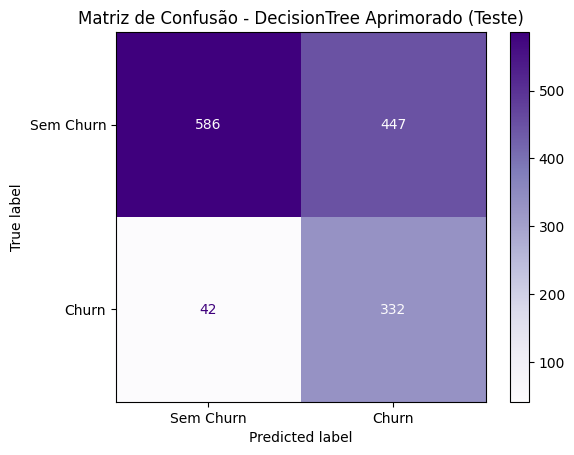

Recall: 0.8877
Precisão: 0.4262
Acurácia: 0.6525
F1-Score: 0.5759


In [151]:
cm = confusion_matrix(y_test, y_pred_test_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sem Churn', 'Churn'])

disp.plot(cmap='Purples')
plt.title('Matriz de Confusão - DecisionTree Aprimorado (Teste)')
plt.show()

recall = recall_score(y_test, y_pred_test_dt)
precision = precision_score(y_test, y_pred_test_dt)
accuracy = accuracy_score(y_test, y_pred_test_dt)
f1 = f1_score(y_test, y_pred_test_dt)

# Imprimir os resultados
print("Recall:", round(recall, 4))
print("Precisão:", round(precision, 4))
print("Acurácia:", round(accuracy, 4))
print("F1-Score:", round(f1, 4))

## *Random Forest*

In [148]:
y_pred_test_rf = grid_rf.best_estimator_.predict(X_test)
print("Recall no teste:", recall_score(y_test, y_pred_test_rf))

Recall no teste: 0.8155080213903744


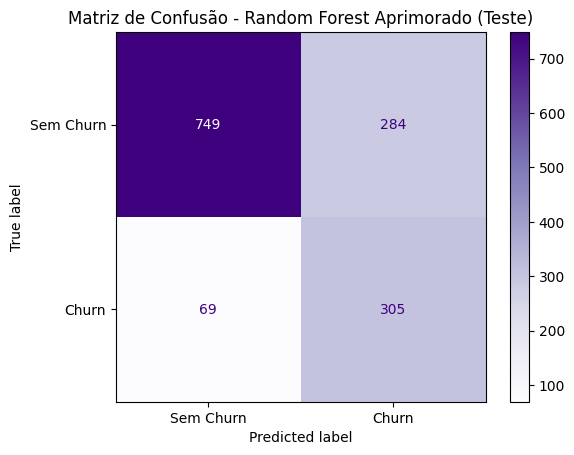

Recall: 0.8155
Precisão: 0.5178
Acurácia: 0.7491
F1-Score: 0.6334


In [157]:
cm = confusion_matrix(y_test, y_pred_test_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sem Churn', 'Churn'])

disp.plot(cmap='Purples')
plt.title('Matriz de Confusão - Random Forest Aprimorado (Teste)')
plt.show()

recall = recall_score(y_test, y_pred_test_rf)
precision = precision_score(y_test, y_pred_test_rf)
accuracy = accuracy_score(y_test, y_pred_test_rf)
f1 = f1_score(y_test, y_pred_test_rf)

# Imprimir os resultados
print("Recall:", round(recall, 4))
print("Precisão:", round(precision, 4))
print("Acurácia:", round(accuracy, 4))
print("F1-Score:", round(f1, 4))

## *Logistic Regression*


In [153]:
y_pred_test_lr = grid_lr.best_estimator_.predict(X_test)
print("Recall no teste:", recall_score(y_test, y_pred_test_lr))

Recall no teste: 0.8128342245989305


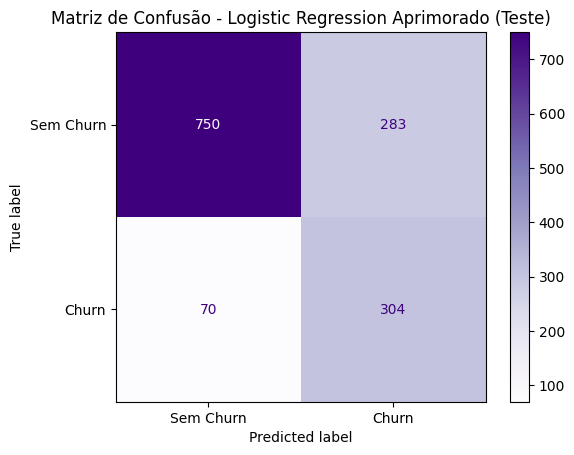

Recall: 0.8128
Precisão: 0.5179
Acurácia: 0.7491
F1-Score: 0.6327


In [158]:
cm = confusion_matrix(y_test, y_pred_test_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sem Churn', 'Churn'])

disp.plot(cmap='Purples')
plt.title('Matriz de Confusão - Logistic Regression Aprimorado (Teste)')
plt.show()

recall = recall_score(y_test, y_pred_test_lr)
precision = precision_score(y_test, y_pred_test_lr)
accuracy = accuracy_score(y_test, y_pred_test_lr)
f1 = f1_score(y_test, y_pred_test_lr)

# Imprimir os resultados
print("Recall:", round(recall, 4))
print("Precisão:", round(precision, 4))
print("Acurácia:", round(accuracy, 4))
print("F1-Score:", round(f1, 4))

### *XGBoost*

In [141]:
y_pred_test_xgb = grid_xgb.best_estimator_.predict(X_test)
print("Recall no teste:", recall_score(y_test, y_pred_test_xgb))

Recall no teste: 0.8181818181818182


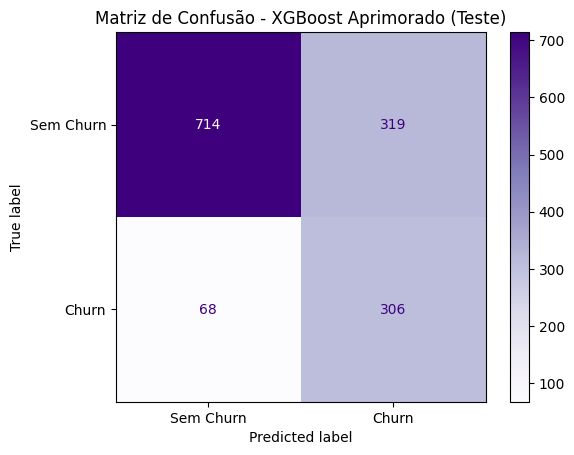

Recall: 0.8182
Precisão: 0.4896
Acurácia: 0.7249
F1-Score: 0.6126


In [152]:
cm = confusion_matrix(y_test, y_pred_test_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sem Churn', 'Churn'])

disp.plot(cmap='Purples')
plt.title('Matriz de Confusão - XGBoost Aprimorado (Teste)')
plt.show()

recall = recall_score(y_test, y_pred_test_xgb)
precision = precision_score(y_test, y_pred_test_xgb)
accuracy = accuracy_score(y_test, y_pred_test_xgb)
f1 = f1_score(y_test, y_pred_test_xgb)

# Imprimir os resultados
print("Recall:", round(recall, 4))
print("Precisão:", round(precision, 4))
print("Acurácia:", round(accuracy, 4))
print("F1-Score:", round(f1, 4))

# Relatório Final
Por meio deste trabalho desenvolvido, foi possível aplicar diferentes técnicas aprendidas durante o curso.

Abaixo, detalho os tópicos aqui abordados.

## Limpeza e tratamento de dados:
Nesta etapa foi analisado todo o dataset que inicialmente estava em arquivo json, sendo necessário tratativa para normalizar e unificar as informações. Posteriormente foi feita tratativa de nulos, valores vazios '', tipos de dados incorretos e remoção da coluna de id. Esta etapa é essencial para uma análise efetiva dos dados.


## Análise exploratória de dados:
Esta etapa foi iniciada com um gráfico de correlação do churn pela categoria de cada variável categória. Esta etapa ajudou muito na pré investigação dos dados, pois foi possível identificar quais categorias tem mais e menos relação com o chun. Ex: A variável Contract com valor Month-to-month tem a maior relação positiva com o churn, enquanto quando essa variável tem valor igual a Two year, possui uma das maiores relações negativas com o churn. Posteriormente foram feitas análises de churn em cima das variáveis categóricas que mais chamaram atenção e em cima das quatro variáveis numéricas.

Finalizada esssa etapa, que havia sido desenvolvida anteriormente, se inicia as etapas para aplicar técnicas de Machine Learning.

## Preparação dos dados para o modelo
Essa etapa complementa a outra limpeza feita, mas agora focada para atender os modelos. Neste trecho foi aplicado o encoding de variáveis binárias e não binárias, além da divisão do dataset em treino e teste.

## Função para treino dos modelos
Visando deixar o código mais limpo, foi criada uma função para treinar os 4 modelos usados neste trabalho, aplicando 2 balanceadores diferentes, resultando em 8 combinações.

Em todas combinações, os modelos foram treinados sem o uso dos hiperparâmetros e coletada a métrica `recall`. O modelo LogisticRegression e XGBoots com balanceador undersampling foram escolhidos para serem aprimorados na próxima etapa.

O `recall` é utilizado como métrica de avaliação do modelo pois:
- **Recall** (ou **sensibilidade**) mede **quantos dos verdadeiros 'churners' o modelo conseguiu identificar.**
- Ou seja, dos clientes que realmente saíram, **quantos o modelo previu corretamente como churn**.

## Aprimoramento dos hiperparâmetros
Foram aplicadas algumas milhares de combinações, e no final o melhor `recall` obtido foi do modelo DecisionTree.

Posteriormente, foram identificadas as variáveis mais importantes para este último modelo, e as mais importantes coincidiam com as variáveis levantadas anteriormente na etapa "correlação entre variáveis com a variável churn".

## Validando o modelo com dados de teste
Por fim, foram escolhidas melhores combinações para cada um dos modelos testados. Os modelos de RandomForest, Logistic Regression e XGBoost ficaram muito próximos nos resultados, sendo mais equilibrados entre `recall`e `precision`.

Já o DecisionTree teve o melhor `recall`, identificando aproximadamente 89% dos churns. Entretanto, ele é o que mais sofre com falsos positivos.

Cabe a empresa decidir qual destes modelos escolher. Caso o custo de falsos positivos não seja problema, o DecisionTree será a melhor escolha, caso contrário pode optar por um dos outros 3.

| Métrica     | DecisionTree | RandomForest | LogisticRegression | XGBoost | Descrição                                                                 |
|-------------|--------------|---------------|---------------------|---------|---------------------------------------------------------------------------|
| Recall      | **0.8877**      | 0.8155        | 0.8128              | 0.8182  | Proporção de clientes que realmente saíram (churn) e foram corretamente identificados. Alta sensibilidade. |
| Precisão    | 0.4262       | 0.5178        | 0.5179              | 0.4896  | Proporção de previsões de churn que estavam corretas. Alta precisão significa menos falsos positivos.       |
| Acurácia    | 0.6525       | 0.7491        | 0.7491              | 0.7249  | Proporção total de acertos (churn e não churn) entre todas as previsões.                                     |
| F1-Score    | 0.5759       | **0.6334**        | 0.6327              | 0.6126  | Média harmônica entre precisão e recall. Mede o equilíbrio entre detectar churn e evitar falsos positivos.  |

Abaixo é ilustrada a matriz de confusão do modelo RandomForest aprimorado.
*   Verdadeiros positivos: (749) O modelo previu “sem churn” e o cliente realmente ficou.
*   Falsos positivos: (284) O modelo previu “vai sair”, mas o cliente ficou. Isso pode gerar custo desnecessário, como dar desconto para quem não ia sair.
*   Falsos negativos: (69) O modelo previu “vai ficar”, mas o cliente saiu.
*   Verdadeiros positivos: (305) O modelo previu “vai sair” e o cliente realmente saiu.
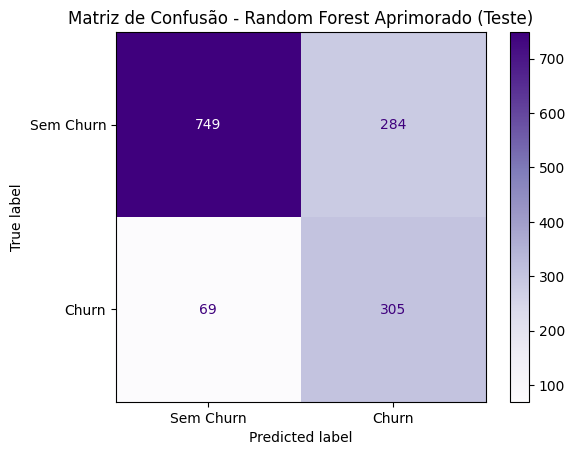


## Ações a serem tomadas para tentar reduzir o churn
Baseado nos resultados e nas variáveis usadas, a empresa pode buscar formas de fidelizar o cliente, garantindo que eles possuam contratos mais longos ao invés de mensais. Essa é uma ação bem comum em empresas de telecom, onde é possível ofertar preços melhores ou produtos agregados para contratos mais longos.

Outro ponto imporante, é que o tipo de internet "fibra ótica" se mostrou importante na decisão dos clientes evadirem. Esse tipo de tecnologia é geralmente muito rápida e robusta, mas nesse caso pode mostrar que existe algum problema, seja de capacidade de rede, excessivas quedas ou interrupções longas. A empresa, junto com a equipe técnica e engenharia de capacidade pode avaliar melhor caso, cruzando com reclamações de clientes para detectarem a causa raiz.

Quanto ao modelo a ser usado, vai depender se a empresa busca um número maior de acertos no churn sem se preocupar com os falsos positivos, ou se preferem ter um balanceamento entre entre esses dois números. Campanhas para evitar o churn podem ser custosas e a empresa precisa se planejar bem para esta ação.


